In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.data import AUTOTUNE

2023-03-07 14:50:04.729773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = keras.models.load_model('neural_net')

img_height = 256
img_width = 256
image_dir = "images"
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    labels="inferred",
    class_names=["Austria","Australia"],
    subset="both",
    seed = 0,
    batch_size = batch_size,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width))

def standardize_image(image, label):
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    standardized_image = tf.map_fn(lambda x: (x - mean)/std, image)
    return (standardized_image, label)

train_ds =  train_ds.map(standardize_image)
val_ds = val_ds.map(standardize_image)


train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)


Found 25064 files belonging to 2 classes.
Using 20052 files for training.
Using 5012 files for validation.


In [3]:
def get_attributions(image, label, baseline, m):
    grads = np.zeros((m+1,32, 256,256,3))
    for i in range(m+1):
        current_sample = baseline + (image - baseline)*i/m
        with tf.GradientTape() as g:
            g.watch(current_sample)
            predicted_label = model(current_sample)
            # loss = losses.BinaryCrossentropy(from_logits = False)(label, predicted_label)

            grads[i] = g.gradient(target = predicted_label, sources = current_sample)

    avg_grads = np.average((grads[:-1] + grads[1:]) / 2.0, axis = 0)
    return avg_grads*(image-baseline)

def rescale_image(image, new_min = 0, new_max = 1):
    image_min = np.min(image)
    image_max = np.max(image)
    if image_max - image_min > 0:
        image = (image*(new_max - new_min) + image_max*new_min - image_min*new_max)/(image_max - image_min)
    return image

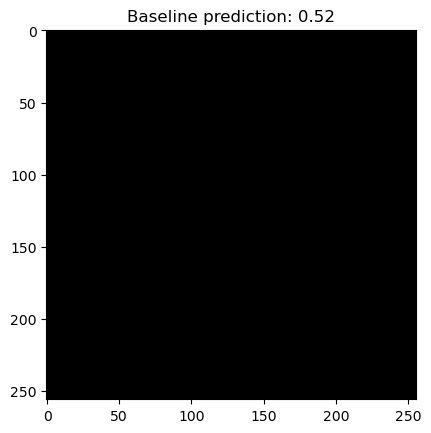

In [4]:
baseline = tf.zeros(shape = ((256,256,3)))

baseline_prediction = model(tf.expand_dims(baseline, axis = 0))
plt.imshow(baseline)
plt.title(f"Baseline prediction: {baseline_prediction[0,0]:.2f}")
plt.show()

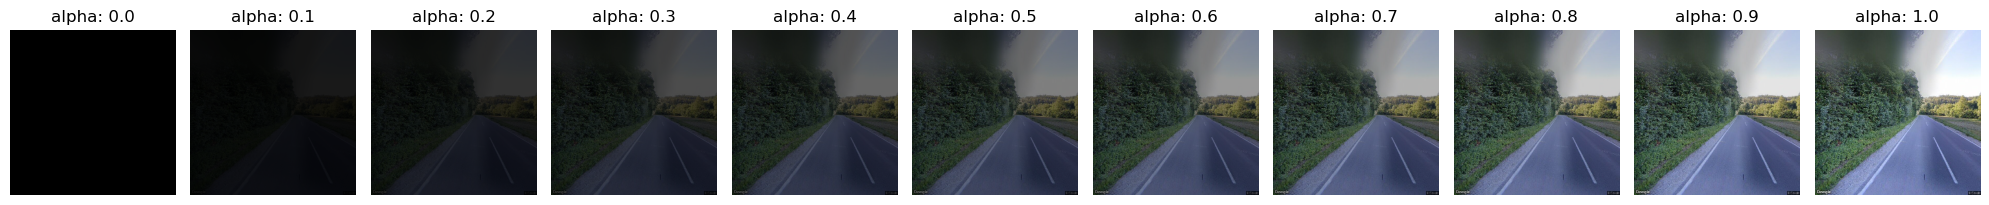

In [5]:
fig = plt.figure(figsize=(20, 20))

for images, labels in val_ds.take(1):
    image = images[0]
    image = rescale_image(image, 0, 1)
    for i, alpha in enumerate(np.linspace(0,1,11)):
      plt.subplot(1, 11, i + 1)
      plt.title(f'alpha: {alpha:.1f}')
      plt.imshow(alpha*image)
      plt.axis('off')

    plt.tight_layout();
plt.show()

In [13]:
def adversarial_transformation(model, eps):

    def func(image, label):

        with tf.GradientTape() as g:
            g.watch(image)
            predicted_label = model(image)
            loss = losses.BinaryCrossentropy()(label, predicted_label)

            gradient = g.gradient(target = loss, sources = image)
            signed_gradient = tf.sign(gradient)
            adv_image = image + signed_gradient * eps

        return adv_image, label
    
    return func

In [26]:
for images, labels in val_ds.take(1):
    attributions = get_attributions(images, labels, baseline, 50)
    predictions = model(images)
    
    adv_images, _ = adversarial_transformation(model, 0.05)(images, labels)
    adv_attributions = get_attributions(adv_images, labels, baseline, 50)
    adv_predictions = model(adv_images)

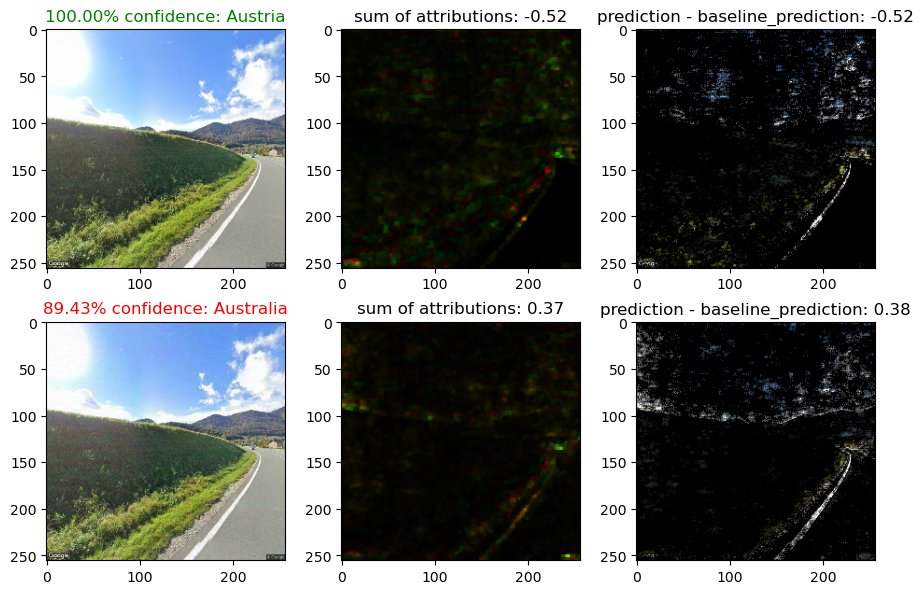

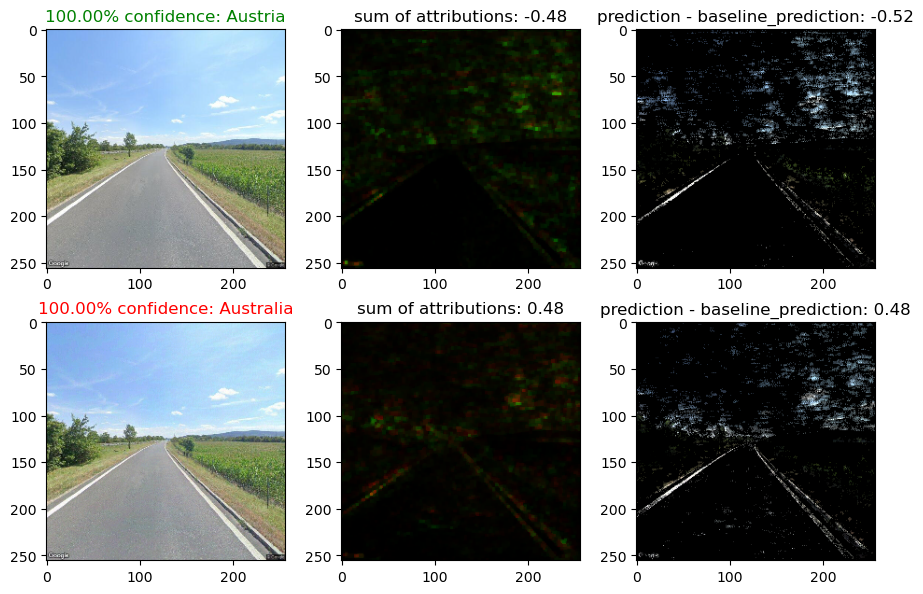

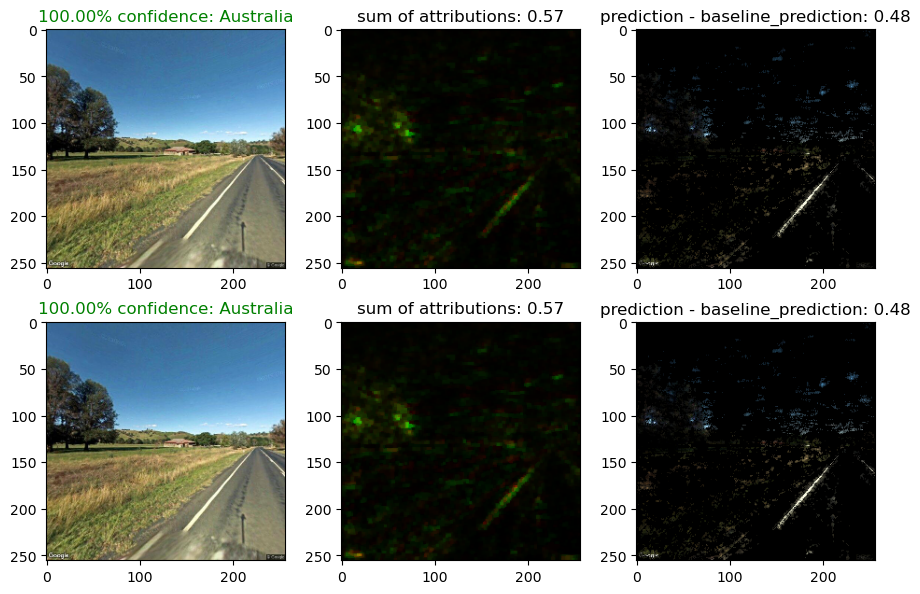

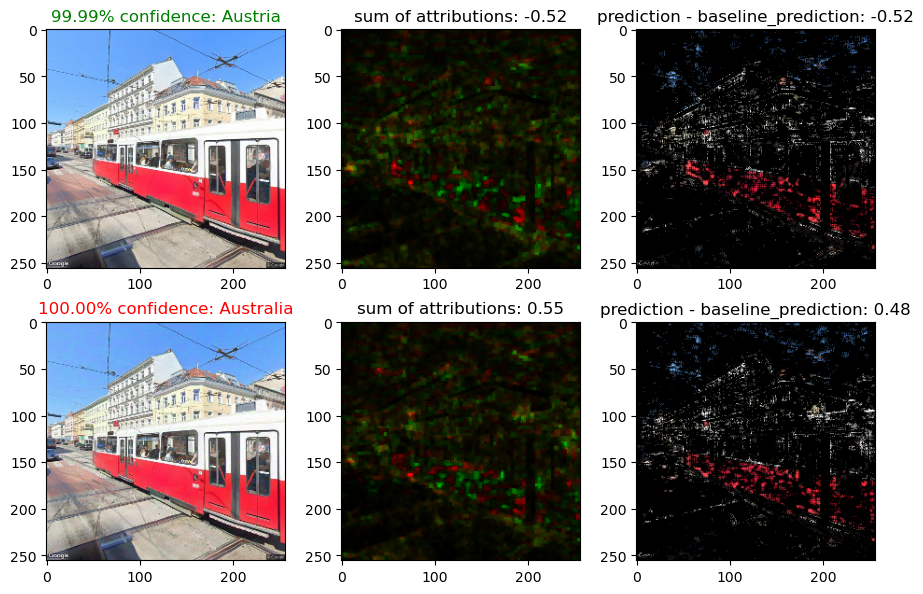

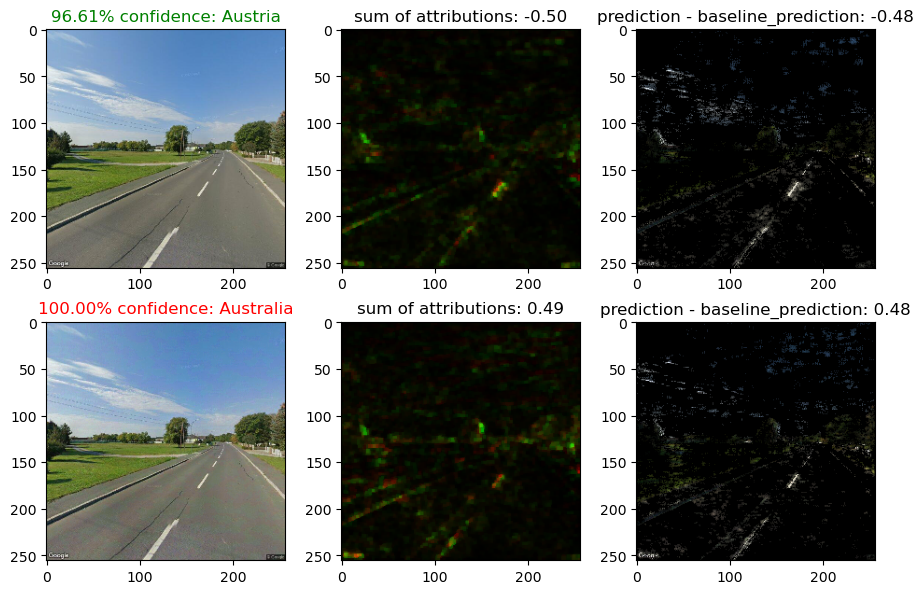

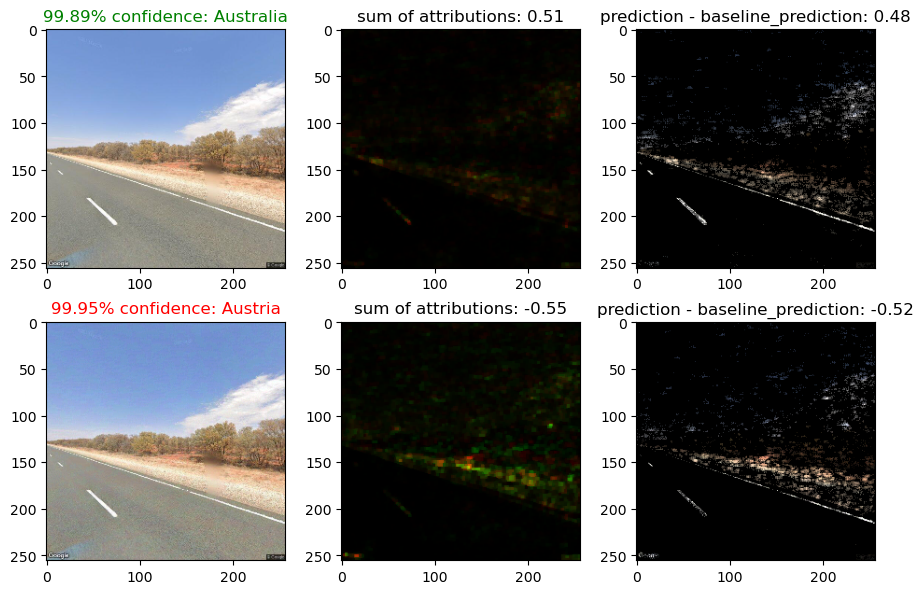

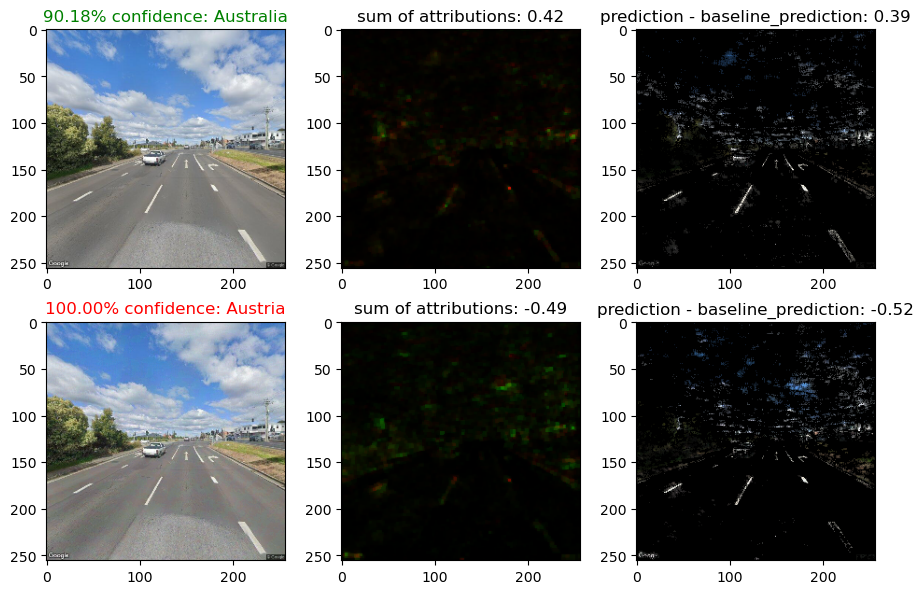

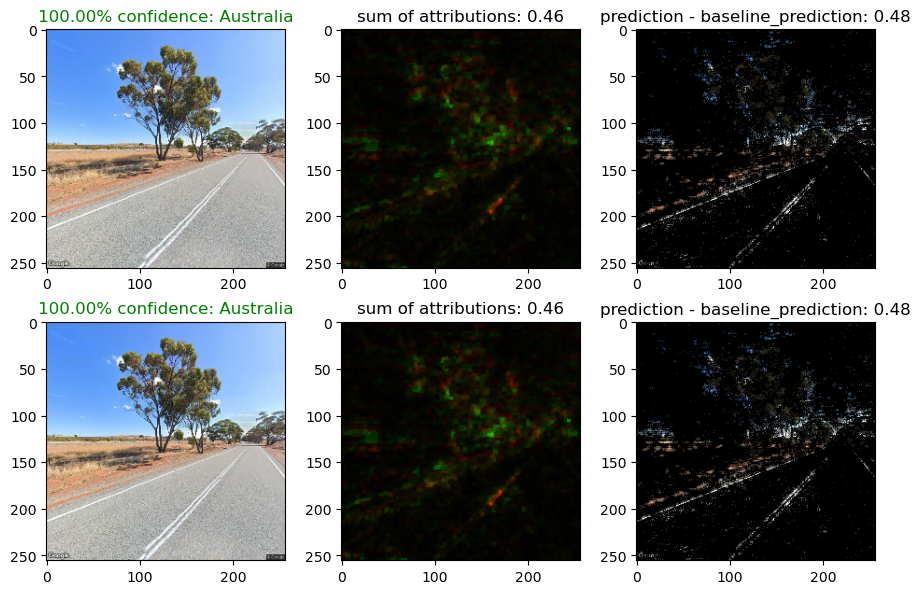

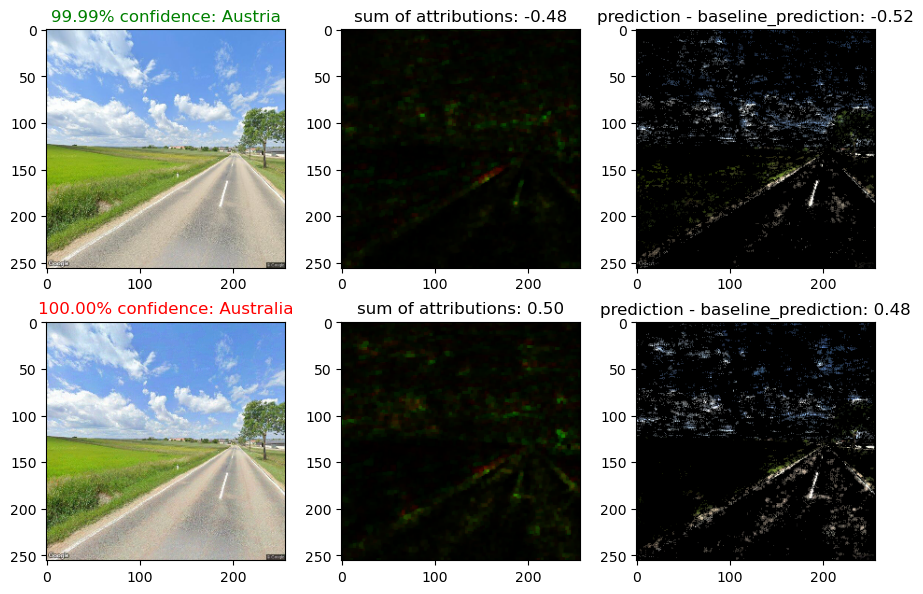

In [34]:
from visualization_lib import Visualize, LinearTransform, pil_image, show_pil_image

def visualize_integrated_gradients(image, label, prediction, integrated_gradients):
    visual_attributions = Visualize(integrated_gradients, np.uint8(rescale_image(image,0,255)[0]), 
                                        polarity = "both", overlay = False, morphological_cleanup = True,
                                       clip_above_percentile=99, clip_below_percentile=0)

    plt.subplot(2,3,3*j+1)
    rescaled_image = rescale_image(image)
    plt.imshow(rescaled_image[0])
    if prediction > 0.5:
        if np.round(prediction) == label:
            plt.title(f"{100*prediction:.2f}% confidence: Australia", color = "green")
        else:
            plt.title(f"{100*prediction:.2f}% confidence: Australia", color = "red")
    else:
        if np.round(prediction) == label:
            plt.title(f"{100*(1-prediction):.2f}% confidence: Austria", color = "green")
        else:
            plt.title(f"{100*(1-prediction):.2f}% confidence: Austria", color = "red")

    plt.subplot(2,3,3*j+2)
    plt.imshow(np.uint8(visual_attributions))
    plt.title(f"sum of attributions: {np.sum(integrated_gradients):.2f}")

    plt.subplot(2,3,3*j+3)

    image = rescale_image(image,0,1)
    aggregated_attributions = LinearTransform(np.average(tf.math.abs(integrated_gradients), axis=2), clip_above_percentile=95,
                clip_below_percentile=50.0,
                low=0.2,
                plot_distribution=False)
    weighted_image = tf.repeat(tf.expand_dims(aggregated_attributions, axis = 2),3, axis = 2)*image
    plt.imshow(rescale_image(weighted_image)[0])
    plt.title(f"prediction - baseline_prediction: {(prediction - baseline_prediction[0,0]):.2f}")

for images, labels in val_ds.take(1):
    selected_images = [6,7,9,14,15,19,20,26,27]
    num_images = len(selected_images)
    
    for i in selected_images:
        plt.figure(figsize= (9,6))
        j = 0
        image = tf.reshape(images[i], (1,256,256,3))
        label = tf.reshape(labels[i], (1,1))
        prediction = predictions[i,0]
        visualize_integrated_gradients(image, label, predictions[i,0], attributions[i])
        j += 1
        
        adv_image = tf.reshape(adv_images[i], (1,256,256,3))
        visualize_integrated_gradients(adv_image, label, adv_predictions[i,0], adv_attributions[i])
        plt.tight_layout()
        plt.show()